# Neural Network Multi-Layer Perceptron Model

In [3]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


## Import and convert data

In [4]:
import pickle

# Load the dataset 6 descriptors
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# Load the dataset Morgan fingerprints
with open("data_splits_fps.pkl", "rb") as f:
    X_train_fps, X_test_fps, y_train_fps, y_test_fps = pickle.load(f)

In [5]:
# Convert data to tensors for compatibility with other libraries
import pandas as pd

def convert_to_tensor(data):
    """
    Convert numpy arrays and pandas datasets to PyTorch tensors.
    """
    if isinstance(data, np.ndarray):
        return torch.tensor(data, dtype=torch.float)
    elif isinstance(data, (pd.DataFrame, pd.Series)):
        return torch.tensor(data.values, dtype=torch.float)
    elif isinstance(data, torch.Tensor):
        return data
    else:
        raise ValueError(f"Unsupported data type: {type(data)}")

X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)
for data in [X_train, y_train, X_test, y_test]:
    print(f"Data type: {type(data)}, Shape: {data.shape}, Device: {data.device}")

Data type: <class 'torch.Tensor'>, Shape: torch.Size([1151, 6]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([1151, 1]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([288, 6]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([288, 1]), Device: cpu


In [6]:
# Convert data to tensors
X_train_fps = convert_to_tensor(X_train_fps)
y_train_fps = convert_to_tensor(y_train_fps)
X_test_fps = convert_to_tensor(X_test_fps)
y_test_fps = convert_to_tensor(y_test_fps)
for data in [X_train_fps, y_train_fps, X_test_fps, y_test_fps]:
    print(f"Data type: {type(data)}, Shape: {data.shape}, Device: {data.device}")

Data type: <class 'torch.Tensor'>, Shape: torch.Size([1151, 512]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([1151, 1]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([288, 512]), Device: cpu
Data type: <class 'torch.Tensor'>, Shape: torch.Size([288, 1]), Device: cpu


## Training and Evaluating classes

In [7]:
class LigBD(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2, verbose=False):
        self.model = model
        # calulate the number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        if verbose==True:
            print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        elif opt_method == "sgdm":
            # Hint: to use SGDM in PyTorch, use torch.optim.SGD and set momentum to a non-zero value
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    #@timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.MSELoss()

        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.float()  # Convert input batch to float32
                y_batch = y_batch.float()  # Convert target batch to float32 (if necessary)
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                            
            # call the evaluate function
            train_loss, _, _ = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            
            val_loss, _, _ = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            plt.figure(figsize=(6, 3))
            plt.plot(x_axis, train_loss_list, label="Train")
            plt.plot(x_axis, val_loss_list, label="Validation")
            plt.title("Loss")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("MSE Loss")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data, draw_curve=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=False)
        y_true, y_pred = [], []
        loss_func = nn.MSELoss()
        loss = 0.0
        for X_batch, y_batch in loader:
            X_batch = X_batch.float()  # Convert input batch to float32
            y_batch = y_batch.float()  # Convert target batch to float32 (if necessary)
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                batch_pred = self.model(X_batch)
                y_true.append(y_batch.cpu())
                y_pred.append(batch_pred.cpu())
                batch_loss = loss_func(batch_pred, y_batch)
                loss += batch_loss.detach().cpu().item() * batch_importance

        y_true = torch.cat(y_true, dim=0).numpy()
        y_pred = torch.cat(y_pred, dim=0).numpy()

        if draw_curve:
            fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 plots

            # Residual Plot
            residuals = y_true - y_pred
            axes[0].scatter(x=y_pred, y=residuals, alpha=0.5)
            axes[0].hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='--')
            axes[0].set_title('Residual Plot')
            axes[0].set_xlabel('Predicted Values')
            axes[0].set_ylabel('Residuals')
            axes[0].grid(True)

            # Prediction vs Actual Plot
            axes[1].scatter(y_true, y_pred, alpha=0.5)
            axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
            axes[1].set_xlabel('True Values')
            axes[1].set_ylabel('Predictions')
            axes[1].set_title('True vs Predicted Ki (Mn)')
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()

            
        return loss, y_true, y_pred            

In [16]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0, draw_curve=False
):
    # Use LigBD to organize data
    test_data = LigBD(X_test, y_test)
    kf = KFold(n_splits=k, shuffle = True, random_state=42)
    train_mse_list, val_mse_list, test_mse_list, test_r2_list = [], [], [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use LigBD to organize data
        train_data = LigBD(X_train[train_index], y_train[train_index])
        val_data = LigBD(X_train[val_index], y_train[val_index])
        
        model = model_class().float()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        print(f'train_data.X.shape: {train_data.X.shape}, val_data.X.shape: {val_data.X.shape}')
        res = trainer.train(train_data, val_data)
        # record the training accuracy of the epoch that has the lowest validation lost
        best_epoch = np.argmin(res["val_loss_list"])
        train_mse_best = res["train_loss_list"][best_epoch]
        val_mse_best = res["val_loss_list"][best_epoch]
        # test, use trainer.evaluate function
        test_mse, y_true, y_pred = trainer.evaluate(test_data, draw_curve=draw_curve)
        test_r2 = r2_score(y_true, y_pred)

        train_mse_list.append(train_mse_best)
        val_mse_list.append(val_mse_best)
        test_mse_list.append(test_mse)
        test_r2_list.append(test_r2)
        
        print(f"Training MSE: {train_mse_best: .4f}")
        print(f"Validation MSE: {val_mse_best: .4f}")
        print(f"Test MSE: {test_mse: .4f}")
        print(f"Test R² Score: {test_r2: .4f}")

    print("\nFinal Results:")
    print(f"Avg Training MSE: {np.mean(train_mse_list):.4f} ± {np.std(train_mse_list):.4f}")
    print(f"Avg Validation MSE: {np.mean(val_mse_list):.4f} ± {np.std(val_mse_list):.4f}")
    print(f"Avg Test MSE: {np.mean(test_mse_list):.4f} ± {np.std(test_mse_list):.4f}")
    print(f"Avg Test R² Score: {np.mean(test_r2_list):.4f} ± {np.std(test_r2_list):.4f}")

In [10]:
# KFold Cross Validation for hyperparameter tuning
def KFoldCrossValidation2(
    model_class, k, 
    X_train, y_train, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    """
    Perform K-Fold Cross Validation without touching the test set.
    Returns average training and validation loss across folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    train_mse_list, val_mse_list = [], []

    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        #print(f"Fold {i+1}/{k}:")

        train_data = LigBD(X_train[train_index], y_train[train_index])
        val_data = LigBD(X_train[val_index], y_train[val_index])
        
        model = model_class().float()
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)

        res = trainer.train(train_data, val_data, early_stop=True, draw_curve=False)

        train_mse_best = res["train_loss_list"][np.argmin(res["val_loss_list"])]
        val_mse_best = res["val_loss_list"][np.argmin(res["val_loss_list"])]

        train_mse_list.append(train_mse_best)
        val_mse_list.append(val_mse_best)

        #print(f"Train MSE (best): {train_mse_best:.4f}")
        #print(f"Val MSE (best):   {val_mse_best:.4f}")

    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)

    return avg_train_mse, avg_val_mse


## Multi Layer Perceptrons

In [11]:
# Simple MLP model
class MLP(nn.Module):
    def __init__(self, input_size=6):
        super(MLP, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
# Deeper MLP model, taylored for hyperparameter tuning
class DeepMLP(nn.Module):
    def __init__(self, input_size=6, hidden_dims=[128, 64], dropout=0.3, activation='relu', batch_norm=False):
        super(DeepMLP, self).__init__()
        
        layers = []
        current_dim = input_size
        
        act_layer = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(negative_slope=0.01)
        }[activation]

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(act_layer)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            current_dim = hidden_dim
        
        layers.append(nn.Linear(current_dim, 1))  # output layer
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

## Training, Validation and Testing

### Dataset 1: Using RDKit Feature Data

#### Simple MLP

Fold 0:
train_data.X.shape: torch.Size([920, 6]), val_data.X.shape: torch.Size([231, 6])


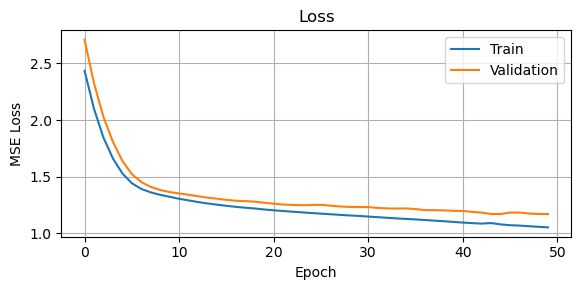

Training MSE:  1.0536
Validation MSE:  1.1708
Test MSE:  1.1287
Test R² Score:  0.3210
Fold 1:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


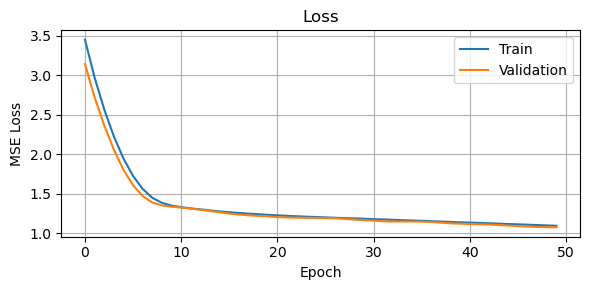

Training MSE:  1.0950
Validation MSE:  1.0753
Test MSE:  1.1679
Test R² Score:  0.2974
Fold 2:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


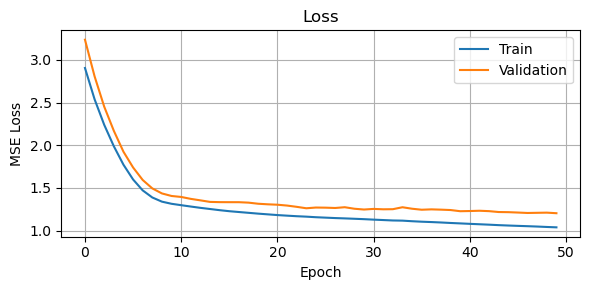

Training MSE:  1.0370
Validation MSE:  1.2027
Test MSE:  1.1562
Test R² Score:  0.3045
Fold 3:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


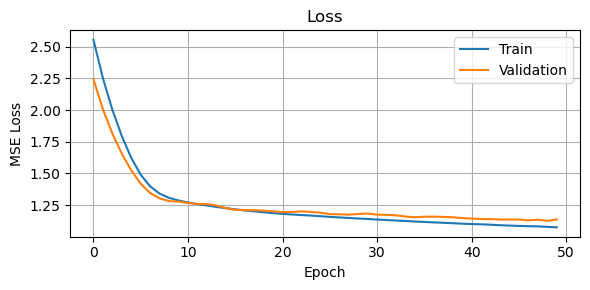

Training MSE:  1.0779
Validation MSE:  1.1259
Test MSE:  1.1437
Test R² Score:  0.3120
Fold 4:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


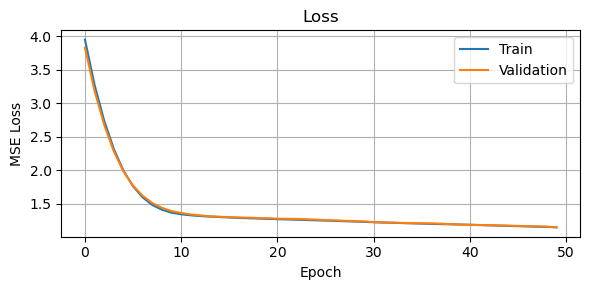

Training MSE:  1.1479
Validation MSE:  1.1474
Test MSE:  1.2367
Test R² Score:  0.2561

Final Results:
Avg Training MSE: 1.0823 ± 0.0384
Avg Validation MSE: 1.1444 ± 0.0429
Avg Test MSE: 1.1666 ± 0.0374
Avg Test R² Score: 0.2982 ± 0.0225


In [19]:
model_class= lambda: MLP(input_size=X_train.shape[1])
k=5
KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
)

#### Hyperparameter tuning

In [13]:
# Hyperparameters
learning_rates = [1e-2, 1e-3, 5e-4]
batch_size=[32, 64, 128]
l2_regs = [0, 1e-5, 1e-4, 1e-3]
dropouts = [0, 0.2, 0.3, 0.5, 0.7]
hidden_dims_list = [[128, 64], [256, 128, 64], [512, 256, 128]]
activations = ['relu', 'gelu', 'leaky_relu']
batch_norm_options = [False, True]

best_val_loss = float('inf')
best_config = None
verbose=False
epoch=200
k=5

In [ ]:
from itertools import product
import os

# Create a subfolder named MLP_config
# Make sure the directory exists
os.makedirs("MLP_config", exist_ok=True)

# Open the file inside the MLP_config subfolder
log_file = open("MLP_config/MLP_hyperparam_search_log.txt", "w")

for lr, bs, l2, do, hidden_dims, act, bn in product(
    learning_rates, batch_size, l2_regs, dropouts, 
    hidden_dims_list, activations, batch_norm_options):
    
    config_desc = f"\n🔧 Testing: LR={lr}, Batch Size={bs}, L2={l2}, Dropout={do}"
    log_file.write(config_desc + "\n")
    
    model_class = lambda: DeepMLP(
        input_size=X_train.shape[1], 
        hidden_dims=hidden_dims, 
        dropout=do, 
        activation=act,
        batch_norm=bn
    )

    avg_train_loss, avg_val_loss = KFoldCrossValidation2(
        model_class=model_class,
        k=k,
        X_train=X_train, y_train=y_train,
        opt_method='adam',
        learning_rate=lr,
        batch_size=bs,
        epoch=epoch,
        l2=l2
    )

    result_summary = (f"✅ Cross-Validation Results over {k} folds:\n"
                      f"→ Avg Train MSE: {avg_train_loss:.4f}\n"
                      f"→ Avg Val MSE:   {avg_val_loss:.4f}\n")
    log_file.write(result_summary + "\n")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_config = (lr, bs, l2, do)

  0%|          | 0/200 [00:00<?, ?it/s]

 84%|████████▍ | 168/200 [00:06<00:01, 22.46it/s]   

In [ ]:
# Retrieve the best configuration
import re

best_val_loss = float('inf')
best_config = None

with open("MLP_config/MLP_hyperparam_search_log.txt", "r") as f:
    lines = f.readlines()

current_config = None

for i, line in enumerate(lines):
    # Match configuration line
    if line.startswith("🔧 Testing:"):
        current_config = line.strip()  # Save current config
        temp_lines = [line]
    # Match validation MSE line
    elif "→ Avg Val MSE:" in line:
        match = re.search(r"→ Avg Val MSE:\s+([0-9.]+)", line)
        if match:
            val_loss = float(match.group(1))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = current_config
                best_config_lines = temp_lines.copy()
    elif current_config and temp_lines:
        temp_lines.append(line)

print("✅ Best Config Found:")
print(best_config)
print(f"With Validation MSE: {best_val_loss:.4f}")

✅ Best Config Found:
🔧 Testing: LR=0.01, Batch Size=32, L2=0.0001, Dropout=0
With Validation MSE: 0.5916


In [ ]:
import pickle

# Define the full best config as a dictionary
best_config = {
    "learning_rate": 0.01,
    "batch_size": 32,
    "l2": 1e-4,
    "dropout": 0,
    "hidden_dims": hidden_dims_list[1],         # Set to the correct index you recovered earlier
    "activation": activations[1],               # Same here
    "batch_norm": batch_norm_options[0]         # And here
}

# Save a human-readable summary to a TXT file
with open("MLP_best_recovered_config.txt", "w") as f:
    f.write("✅ Best Config:\n")
    f.write(f"Learning Rate = {best_config['learning_rate']}\n")
    f.write(f"Batch Size    = {best_config['batch_size']}\n")
    f.write(f"L2 Regularization = {best_config['l2']}\n")
    f.write(f"Dropout       = {best_config['dropout']}\n")
    f.write(f"Hidden Dims   = {best_config['hidden_dims']}\n")
    f.write(f"Activation    = {best_config['activation']}\n")
    f.write(f"Batch Norm    = {best_config['batch_norm']}\n")

# Save the actual config dictionary to a pickle file
with open("MLP_config/MLP_best_config.pkl", "wb") as f:
    pickle.dump(best_config, f)

print("✅ Saved human-readable summary and best_config pickle.")

✅ Saved human-readable summary and best_config pickle.


#### Visualize best model performances

Fold 0:
train_data.X.shape: torch.Size([920, 6]), val_data.X.shape: torch.Size([231, 6])


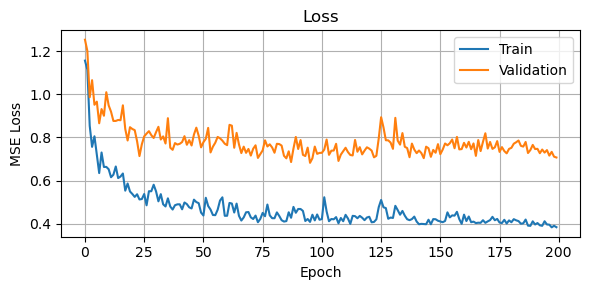

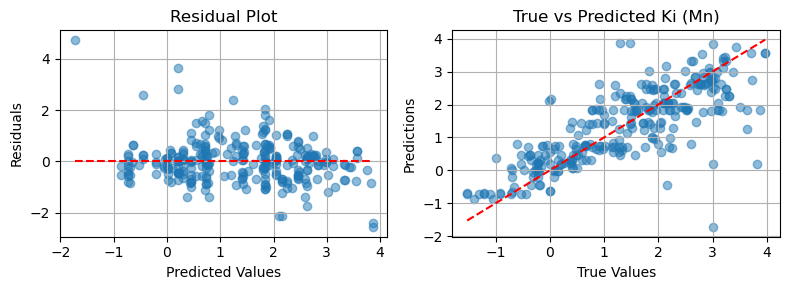

Training MSE:  0.4084
Validation MSE:  0.6821
Test MSE:  0.6613
Test R² Score:  0.6022
Fold 1:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


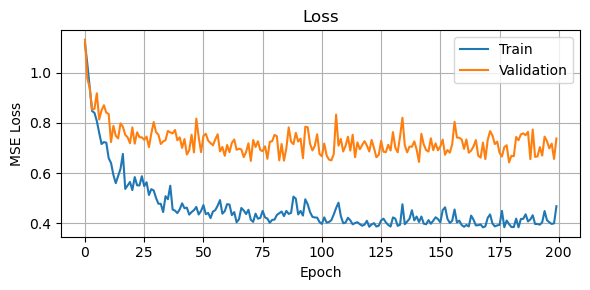

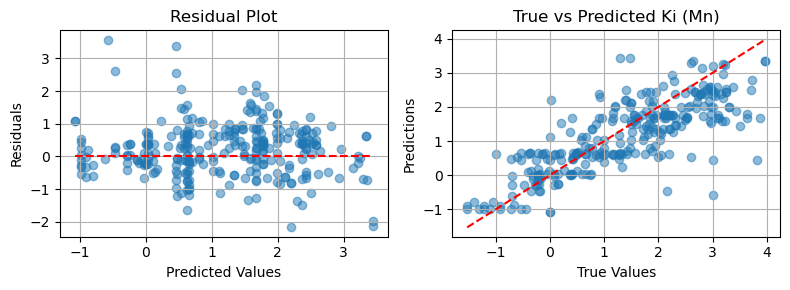

Training MSE:  0.3971
Validation MSE:  0.6426
Test MSE:  0.6728
Test R² Score:  0.5953
Fold 2:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


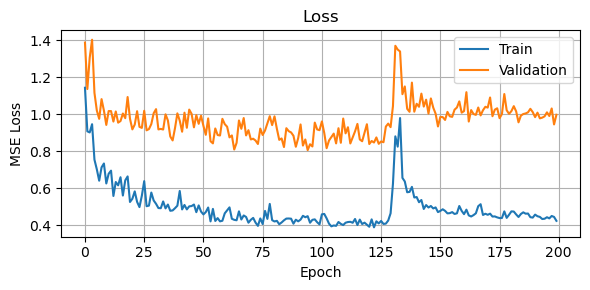

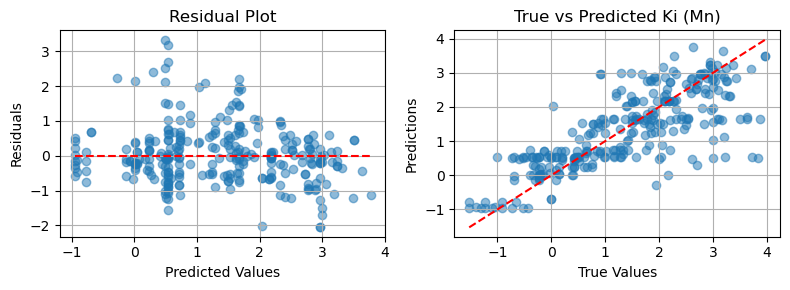

Training MSE:  0.4497
Validation MSE:  0.8067
Test MSE:  0.6839
Test R² Score:  0.5886
Fold 3:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


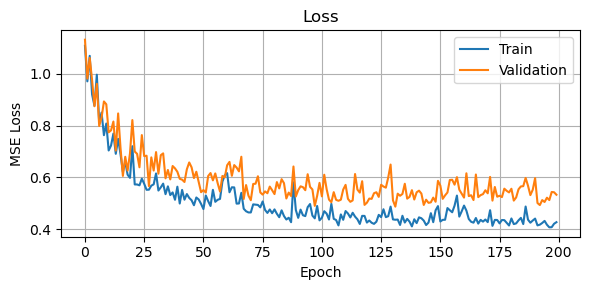

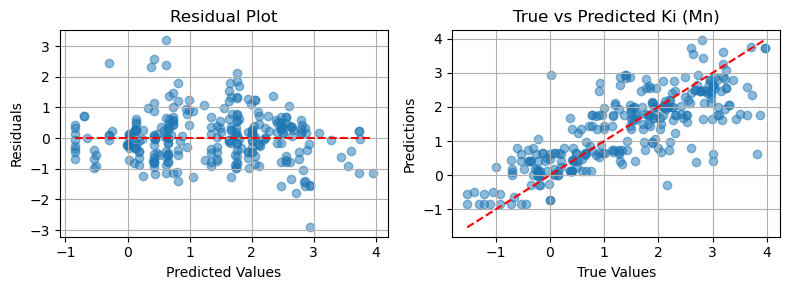

Training MSE:  0.4370
Validation MSE:  0.4875
Test MSE:  0.6264
Test R² Score:  0.6232
Fold 4:
train_data.X.shape: torch.Size([921, 6]), val_data.X.shape: torch.Size([230, 6])


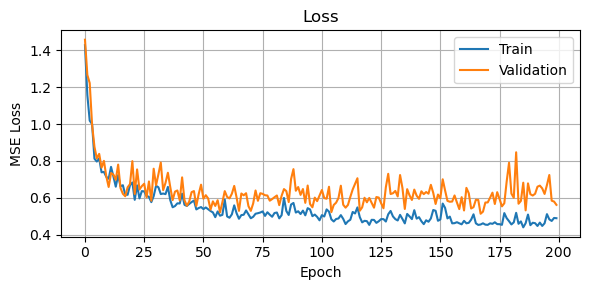

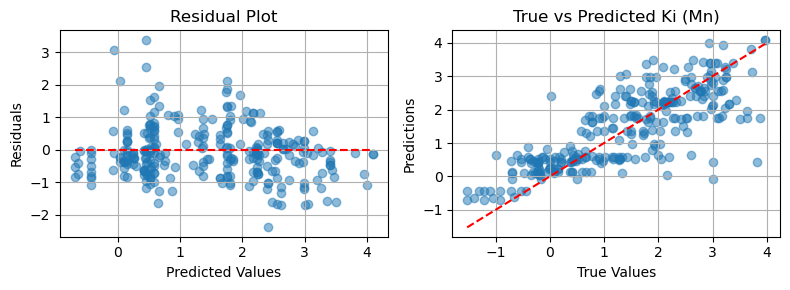

Training MSE:  0.4554
Validation MSE:  0.5138
Test MSE:  0.6434
Test R² Score:  0.6129

Final Results:
Avg Training MSE: 0.4295 ± 0.0229
Avg Validation MSE: 0.6266 ± 0.1165
Avg Test MSE: 0.6576 ± 0.0206
Avg Test R² Score: 0.6044 ± 0.0124


In [20]:
# Load the best configuration from a file
with open("MLP_config/MLP_best_config.pkl", "rb") as f:
    best_config = pickle.load(f)
    

best_model = lambda: DeepMLP(
        input_size=X_train.shape[1], 
        hidden_dims=best_config['hidden_dims'], 
        dropout=best_config['dropout'], 
        activation=best_config['activation'],
        batch_norm=best_config['batch_norm']
    )

k=5
KFoldCrossValidation(
    best_model, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=best_config['learning_rate'], batch_size=best_config['batch_size'], epoch=200, l2=best_config['l2'], draw_curve=True)

### Dataset 2: Using Morgan Fingerprint Data

#### Simple MLP

Fold 0:
train_data.X.shape: torch.Size([920, 512]), val_data.X.shape: torch.Size([231, 512])


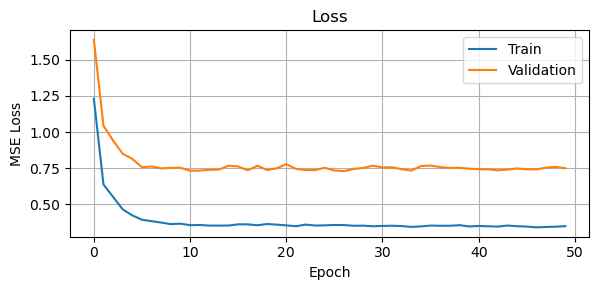

Training MSE:  0.3547
Validation MSE:  0.7283
Test MSE:  0.6550
Test R² Score:  0.6060
Fold 1:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


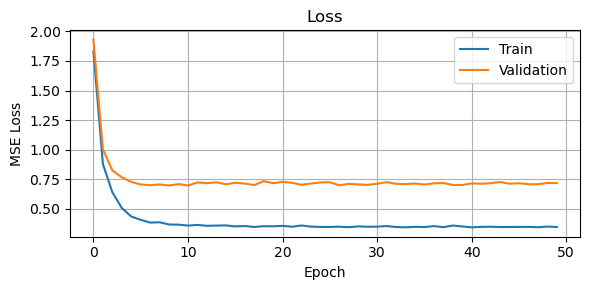

Training MSE:  0.3598
Validation MSE:  0.6980
Test MSE:  0.7468
Test R² Score:  0.5507
Fold 2:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


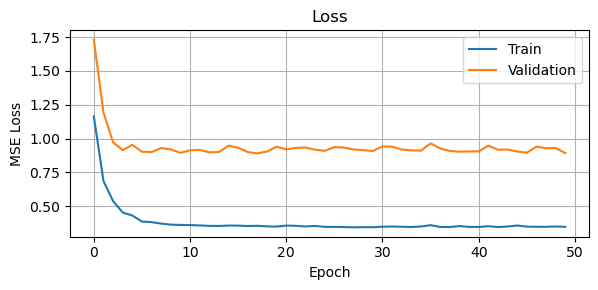

Training MSE:  0.3563
Validation MSE:  0.8912
Test MSE:  0.6592
Test R² Score:  0.6035
Fold 3:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


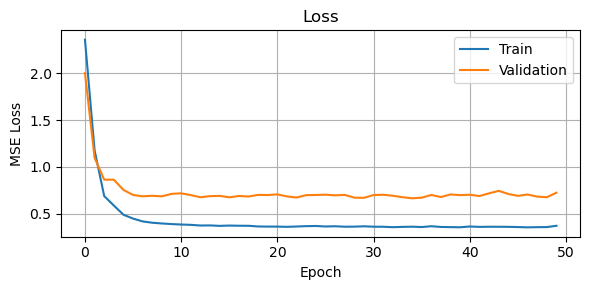

Training MSE:  0.3622
Validation MSE:  0.6657
Test MSE:  0.7370
Test R² Score:  0.5567
Fold 4:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


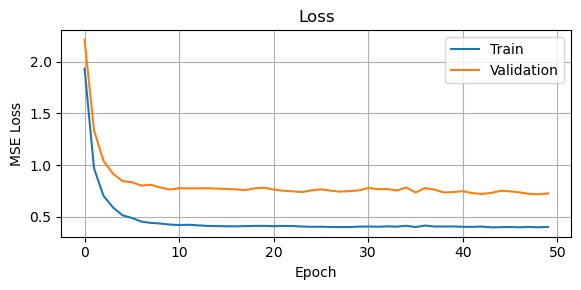

Training MSE:  0.3973
Validation MSE:  0.7170
Test MSE:  0.6603
Test R² Score:  0.6028

Final Results:
Avg Training MSE: 0.3661 ± 0.0158
Avg Validation MSE: 0.7400 ± 0.0785
Avg Test MSE: 0.6917 ± 0.0412
Avg Test R² Score: 0.5839 ± 0.0248


In [21]:
# Simple MLP model for Morgan fingerprints
model_class= lambda: MLP(input_size=X_train_fps.shape[1])
k=5
KFoldCrossValidation(
    model_class, k, 
    X_train_fps, y_train_fps, X_test_fps, y_test_fps, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
)

#### Deeper MLP

Fold 0:
train_data.X.shape: torch.Size([920, 512]), val_data.X.shape: torch.Size([231, 512])


  0%|          | 0/100 [00:00<?, ?it/s]

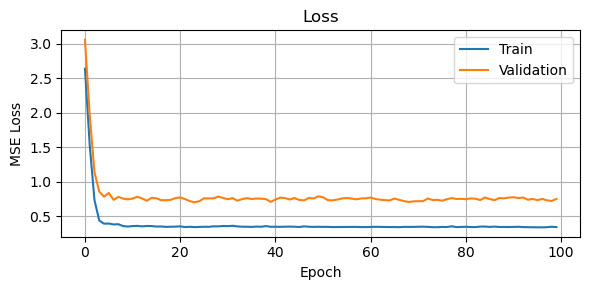

Training MSE:  0.3428
Validation MSE:  0.7026
Test MSE:  0.5187
Test R² Score:  0.6880
Fold 1:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


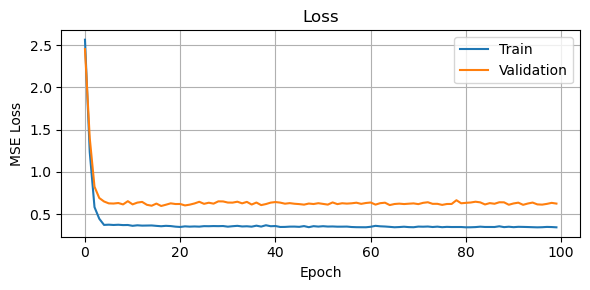

Training MSE:  0.3564
Validation MSE:  0.5962
Test MSE:  0.5413
Test R² Score:  0.6744
Fold 2:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


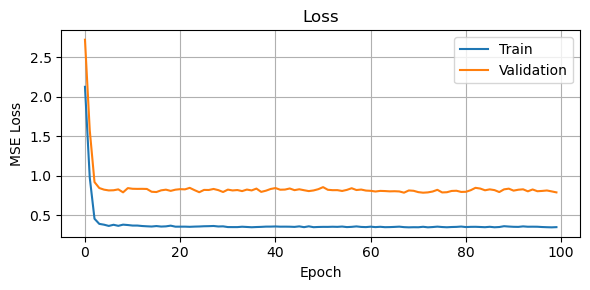

Training MSE:  0.3505
Validation MSE:  0.7831
Test MSE:  0.5386
Test R² Score:  0.6760
Fold 3:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


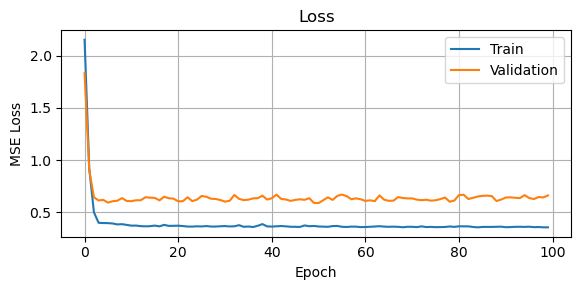

Training MSE:  0.3634
Validation MSE:  0.5880
Test MSE:  0.5963
Test R² Score:  0.6413
Fold 4:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


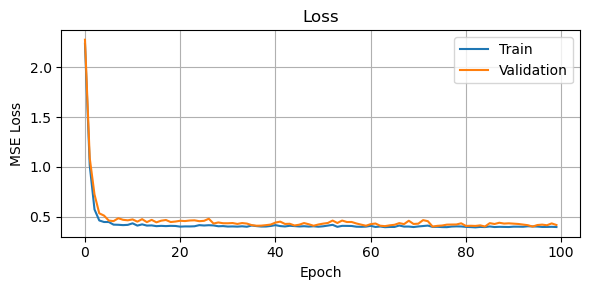

Training MSE:  0.3986
Validation MSE:  0.4018
Test MSE:  0.5515
Test R² Score:  0.6682

Final Results:
Avg Training MSE: 0.3623 ± 0.0193
Avg Validation MSE: 0.6143 ± 0.1284
Avg Test MSE: 0.5493 ± 0.0258
Avg Test R² Score: 0.6696 ± 0.0155


In [22]:
model_class= lambda: DeepMLP(
    input_size=X_train_fps.shape[1], 
    hidden_dims=[256, 128, 64], 
    dropout=0, 
    activation='relu',
    batch_norm=True
    )

k=5
epoch=100
KFoldCrossValidation(
    model_class, k, 
    X_train_fps, y_train_fps, X_test_fps, y_test_fps, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=epoch, l2=0.0
)

#### Hyperparameter tuning

In [46]:
# Hyperparameters
learning_rates = [1e-2, 1e-3]
batch_size=[64, 128]
l2_regs = [0, 1e-5, 1e-4]
dropouts = [0, 0.2, 0.5, 0.7]
hidden_dims_list = [[256, 128, 64]]
activations = ['relu']
batch_norm_options = [True]

best_val_loss = float('inf')
best_config = None
verbose=False
epoch=100
k=5

In [ ]:
from itertools import product

# Open a text file to log results
log_file = open("MLP_config/MLP_hyperparam_search_fps.txt", "w")

for lr, bs, l2, do, hidden_dims, act, bn in product(
    learning_rates, batch_size, l2_regs, dropouts, 
    hidden_dims_list, activations, batch_norm_options):
    
    config_desc = f"\n🔧 Testing: LR={lr}, Batch Size={bs}, L2={l2}, Dropout={do}"
    log_file.write(config_desc + "\n")
    
    model_class = lambda: DeepMLP(
        input_size=X_train_fps.shape[1], 
        hidden_dims=hidden_dims, 
        dropout=do, 
        activation=act,
        batch_norm=bn
    )

    avg_train_loss, avg_val_loss = KFoldCrossValidation2(
        model_class=model_class,
        k=k,
        X_train=X_train_fps, y_train=y_train_fps,
        opt_method='adam',
        learning_rate=lr,
        batch_size=bs,
        epoch=epoch,
        l2=l2
    )

    result_summary = (f"✅ Cross-Validation Results over {k} folds:\n"
                      f"→ Avg Train MSE: {avg_train_loss:.4f}\n"
                      f"→ Avg Val MSE:   {avg_val_loss:.4f}\n")
    log_file.write(result_summary + "\n")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_config = (lr, bs, l2, do)

In [ ]:
# Save a human-readable summary to a TXT file
with open("MLP_config/MLP_best_config_fps.txt", "w") as f:
    f.write("✅ Best Config:\n")
    f.write(f"Learning Rate = {best_config[0]}\n")
    f.write(f"Batch Size    = {best_config[1]}\n")
    f.write(f"L2 Regularization = {best_config[2]}\n")
    f.write(f"Dropout       = {best_config[3]}\n")

# Save the actual config dictionary to a pickle file
with open("MLP_config/MLP_best_config_fps.pkl", "wb") as f:
    pickle.dump(best_config, f)

print("✅ Saved human-readable summary and best_config pickle.")

✅ Saved human-readable summary and best_config pickle.


#### Visualize best model results

Fold 0:
train_data.X.shape: torch.Size([920, 512]), val_data.X.shape: torch.Size([231, 512])


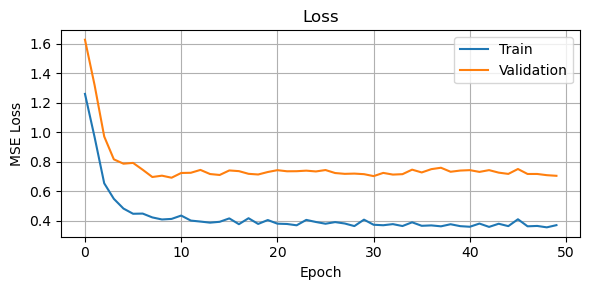

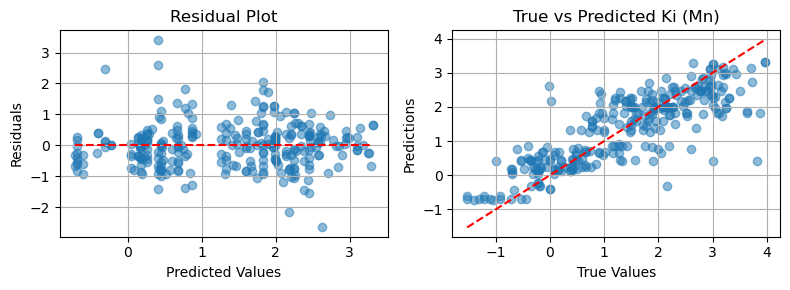

Training MSE:  0.4140
Validation MSE:  0.6930
Test MSE:  0.5193
Test R² Score:  0.6876
Fold 1:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


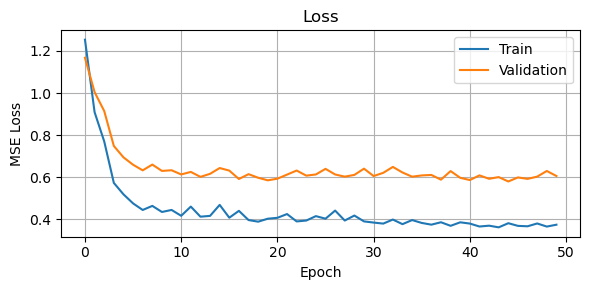

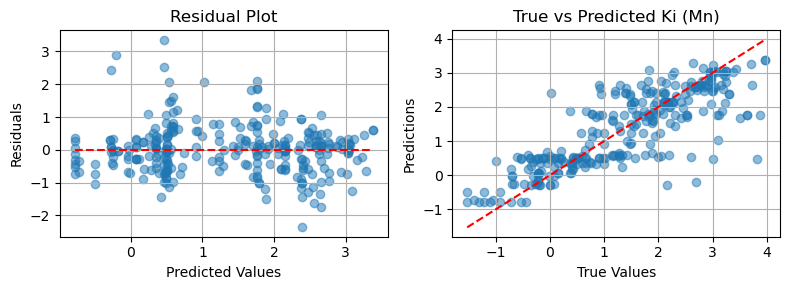

Training MSE:  0.3822
Validation MSE:  0.5803
Test MSE:  0.5591
Test R² Score:  0.6637
Fold 2:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


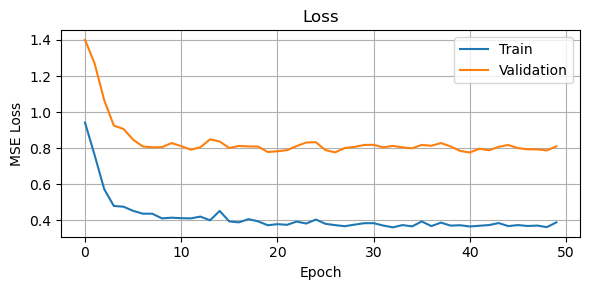

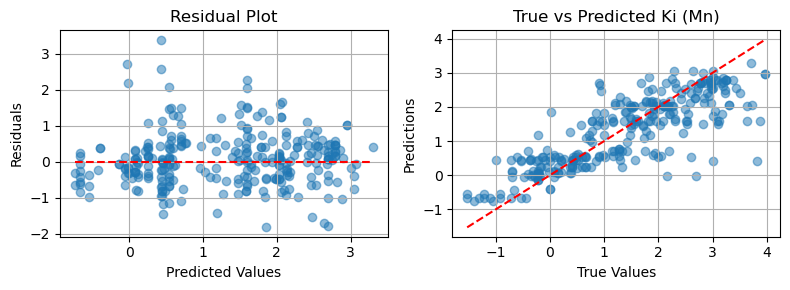

Training MSE:  0.3662
Validation MSE:  0.7764
Test MSE:  0.5546
Test R² Score:  0.6664
Fold 3:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


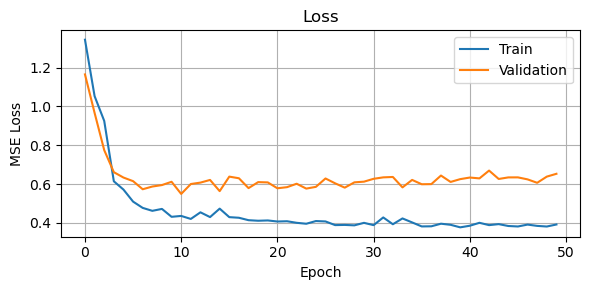

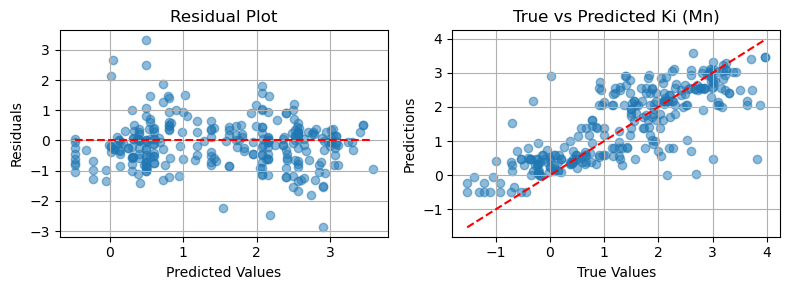

Training MSE:  0.4363
Validation MSE:  0.5496
Test MSE:  0.6139
Test R² Score:  0.6307
Fold 4:
train_data.X.shape: torch.Size([921, 512]), val_data.X.shape: torch.Size([230, 512])


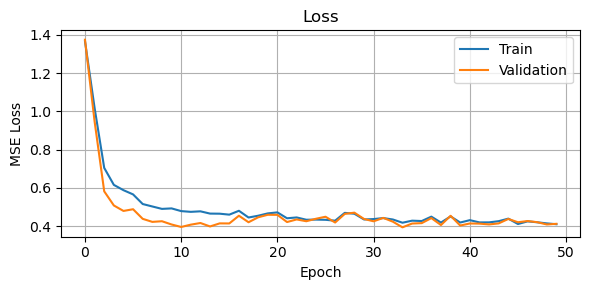

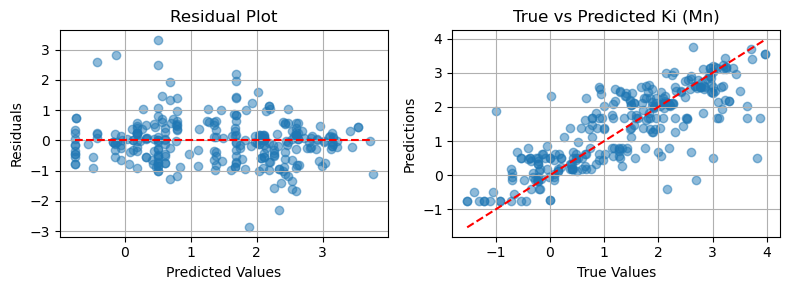

Training MSE:  0.4175
Validation MSE:  0.3934
Test MSE:  0.5559
Test R² Score:  0.6656

Final Results:
Avg Training MSE: 0.4032 ± 0.0254
Avg Validation MSE: 0.5985 ± 0.1307
Avg Test MSE: 0.5605 ± 0.0303
Avg Test R² Score: 0.6628 ± 0.0183


In [ ]:
# Load the best configuration from a file
with open("MLP_config/MLP_best_config_fps.pkl", "rb") as f:
    best_config = pickle.load(f)
    

best_model = lambda: DeepMLP(
        input_size=X_train_fps.shape[1], 
        hidden_dims=[256, 128, 64], 
        dropout=best_config[3], 
        activation='relu',
        batch_norm=True
    )

k=5
KFoldCrossValidation(
    best_model, k, 
    X_train_fps, y_train_fps, X_test_fps, y_test_fps, 
    opt_method='adam', learning_rate=best_config[0], batch_size=best_config[1], epoch=50, l2=best_config[2], draw_curve=True)

## Final Summary of results:

#### Best Average Train MSE and Test MSE achieved with DeepMLP on Morgan fingerprints data:  

- Avg Training MSE: 0.3623 ± 0.0193
- Avg Validation MSE: 0.6143 ± 0.1284
- Test MSE: 0.5493 ± 0.0258
- Test R² Score: 0.6696 ± 0.0155